# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for aggregate module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename
from lib.aggregate.cell_classification import CellClassifier
from lib.aggregate.montage_utils import create_cell_montage, add_filenames
from lib.aggregate.filter import (
    load_parquet_subset,
    perturbation_filter,
    visualize_nas,
    missing_values_filter,
)
from lib.aggregate.align import prepare_alignment_data, pca_variance_plot, embed_by_pca, tvn_on_controls
from lib.aggregate.aggregate import aggregate
from lib.aggregate.eval_aggregate import plot_feature_distributions, summarize_cell_data
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

## <font color='red'>SET PARAMETERS</font>

### Testing on subset of data

- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL`: Well identifier used for testing configuration

In [3]:
TEST_PLATE = 1
TEST_WELL = "A1"

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=50000)
display(cell_data)

print("First 20 columns; use to set parameters below.")
for index, col in enumerate(cell_data.columns[:20]):
    print(index, col)

Reading first 50,000 rows from analysis_root/merge/parquets/P-1_W-A1__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1045,429,1478.403947,1481.714474,243,254,100.607843,670.117647,...,0,0.000000,48.501317,54.812638,164.492958,0.0,0.000000,48.482563,55.773102,160.427741
1,1,A1,401,485,1477.766431,1478.877654,101,294,100.089552,669.910448,...,1,0.049751,45.269871,62.882030,106.480590,1.0,0.028818,40.760186,57.586665,116.482954
2,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
3,1,A1,595,475,1480.676399,1482.874696,154,221,100.764706,670.764706,...,2,0.193548,36.794933,52.151249,171.453465,2.0,0.040404,39.327858,47.072292,154.575718
4,1,A1,1479,601,1477.695030,1481.850904,365,346,99.764045,671.494382,...,0,0.000000,57.697175,61.333366,138.748450,0.0,0.000000,62.644570,63.731803,133.933684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A1,1125,453,1480.076923,1755.965545,278,220,100.432099,168.814815,...,1,0.027778,51.719049,57.920520,168.921134,1.0,0.015625,52.825726,62.730908,168.160355
49996,1,A1,1408,731,1753.173077,1440.839744,338,2338,739.098765,92.271605,...,0,0.000000,63.654194,75.970693,59.774914,0.0,0.000000,65.328179,79.941206,91.112332
49997,1,A1,525,334,1227.967429,1592.447678,120,1347,608.121212,697.919192,...,0,0.000000,52.176829,59.403882,169.852034,0.0,0.000000,49.825625,59.247234,172.702028
49998,1,A1,56,503,1600.628225,1728.227618,19,350,130.087379,160.582524,...,0,0.000000,60.944246,69.059469,44.366065,0.0,0.000000,62.061594,64.824308,55.486461


First 20 columns; use to set parameters below.
0 plate
1 well
2 tile
3 cell_0
4 i_0
5 j_0
6 site
7 cell_1
8 i_1
9 j_1
10 distance
11 fov_distance_0
12 fov_distance_1
13 sgRNA_0
14 gene_symbol_0
15 mapped_single_gene
16 channels_min
17 nucleus_DAPI_int
18 nucleus_COXIV_int
19 nucleus_CENPA_int


## <font color='red'>SET PARAMETERS</font>

### Split cells into types

- `CLASSIFIER_PATH`: Path to pickled Python object that can take a cell data dataframe and output cell classes
- `FIRST_FEATURE`: Name of first feature in cell data (see first 20 cols above). Usually `nucleus_DAPI_int`
- `MONTAGE_CHANNEL`: Channel to use for montage generation. Usually `DAPI`

**Note**: Any Python packages necessary for the loaded cell classifier must be imported here as well.

In [5]:
CLASSIFIER_PATH = "config/naive_mitotic_classifier.pkl"
FIRST_FEATURE = "nucleus_DAPI_int"
MONTAGE_CHANNEL = "DAPI"

"""
IMPORT PACKAGES NECESSARY FOR CLASSIFIER
"""
from sklearn.preprocessing import RobustScaler
import numpy as np

Cell class counts:
class
interphase    49538
mitotic         462
Name: count, dtype: int64
Cell class confidences:


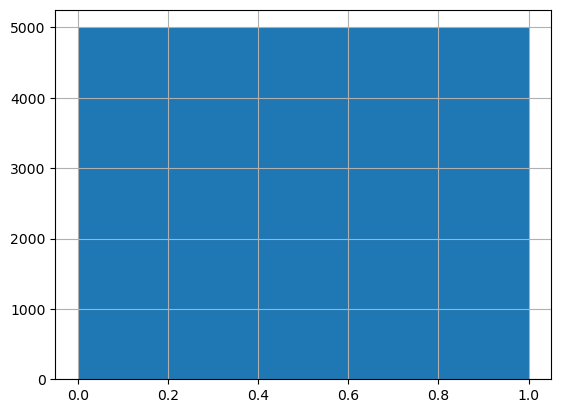

In [6]:
classifier = CellClassifier.load(CLASSIFIER_PATH)
classes, confidences = classifier.classify_cells(cell_data, FIRST_FEATURE)

# Insert the arrays as new columns before the feature columns
feature_start_idx = cell_data.columns.get_loc(FIRST_FEATURE)
cell_data.insert(feature_start_idx, "class", classes)
cell_data.insert(feature_start_idx + 1, "confidence", confidences)

# Create config var for cell classes
CELL_CLASSES = list(cell_data["class"].unique())
DATASETS = ["all"] + CELL_CLASSES

print("Cell class counts:")
print(cell_data["class"].value_counts())

print("Cell class confidences:")
cell_data["confidence"].hist()
plt.show()

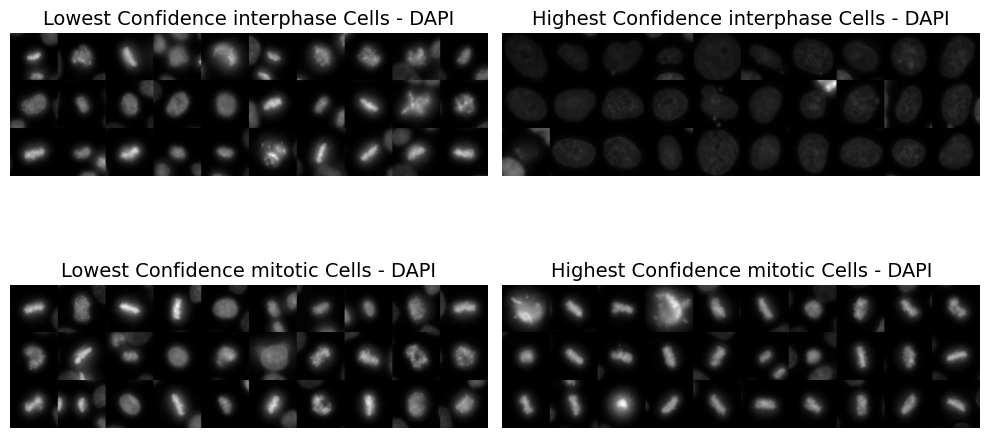

In [7]:
classified_cell_data = cell_data.copy()
classified_cell_data = add_filenames(classified_cell_data, ROOT_FP)

# Create a dictionary of DataFrames for each cell class
cell_class_dfs = {
    cell_class: classified_cell_data[classified_cell_data["class"] == cell_class]
    for cell_class in CELL_CLASSES
}

# Define sorting directions and titles
title_templates = {
    True: "Lowest Confidence {cell_class} Cells - {channel}",
    False: "Highest Confidence {cell_class} Cells - {channel}",
}

# Generate montages dynamically
montages, titles = [], []
for cell_class, cell_df in cell_class_dfs.items():
    for ascending in [True, False]:
        montage = create_cell_montage(
            cell_data=cell_df,
            channels=config["phenotype"]["channel_names"],
            selection_params={
                "method": "sorted",
                "sort_by": "confidence",
                "ascending": ascending,
            },
        )[MONTAGE_CHANNEL]
        montages.append(montage)
        titles.append(title_templates[ascending].format(cell_class=cell_class, channel=MONTAGE_CHANNEL))

# Determine figure size dynamically
num_rows = len(CELL_CLASSES)
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))

# Display montages
for ax, title, montage in zip(axes.flat, titles, montages):
    ax.imshow(montage, cmap="gray")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Perturbation filtering

- `PERTURBATION_NAME_COL`: Name of column used to identify perturbation
- `PERTURBATION_MULTI_COL`: Name of column that has a boolean flag for if multiple perturbations are detected
- `FILTER_SINGLE_PERT`: Whether or not to only keep cells that have a single perturbation

Found 22753 cells with assigned perturbations
Unique populations: 4601
Columns with high NA value percent:
  - cytoplasm_DAPI_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_COXIV_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_CENPA_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_WGA_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_DAPI_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_COXIV_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_CENPA_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_WGA_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_DAPI_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_COXIV_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_CENPA_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_WGA_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_DAPI_radial_cv_1: 14838 NAs (65.21%)
  - cytoplasm_COXIV_radial_cv_1: 14838 NAs (65.21%)
  - cytoplasm_CENPA_radial_cv_1: 14838 NAs (65.21%)
  - cytoplasm_WGA_radial_cv_1: 14838 NAs (65.21%)


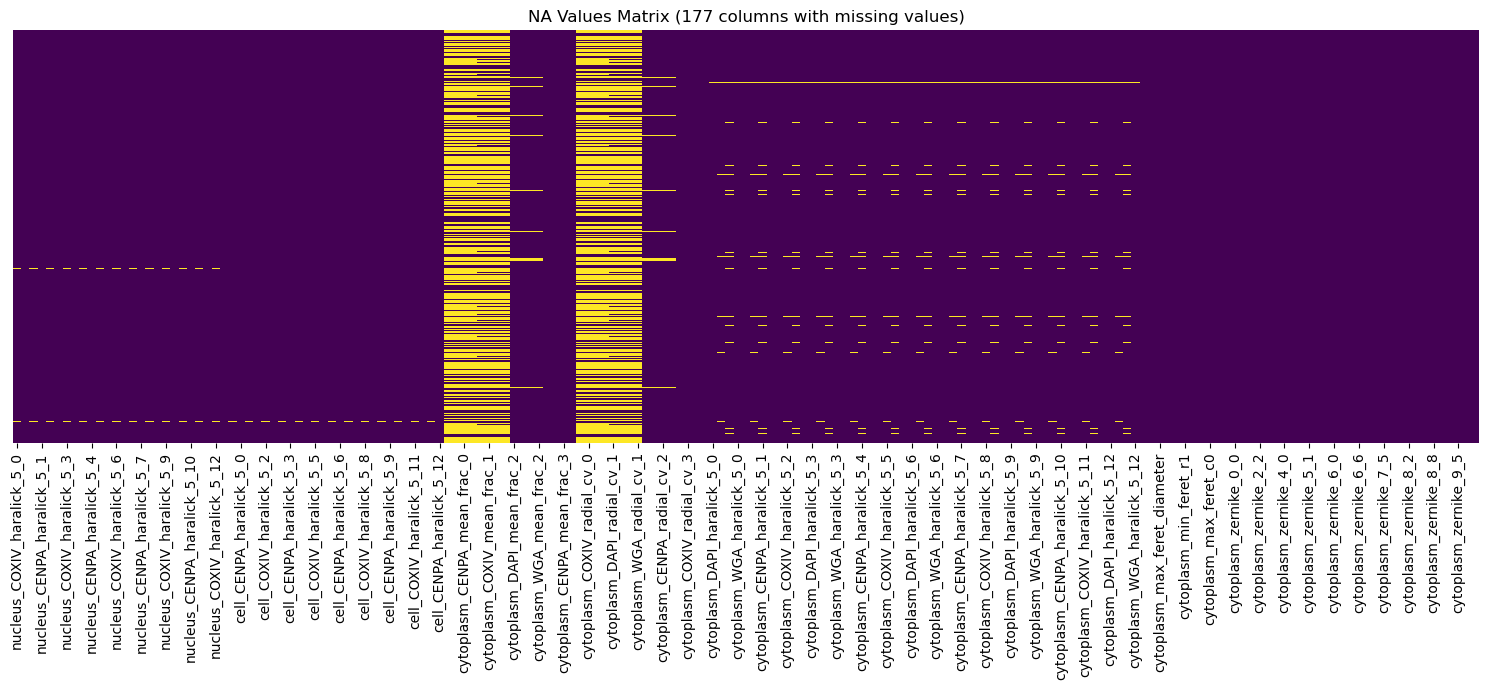

In [8]:
PERTURBATION_NAME_COL = "gene_symbol_0"
PERTURBATION_MULTI_COL = "mapped_single_gene"
FILTER_SINGLE_PERT = False

perturbation_filtered = perturbation_filter(
    cell_data, PERTURBATION_NAME_COL, PERTURBATION_MULTI_COL, FILTER_SINGLE_PERT
)
print(f"Unique populations: {perturbation_filtered[PERTURBATION_NAME_COL].nunique()}")

fig = visualize_nas(perturbation_filtered)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Missing value filtering

- `DROP_COLS_THRESHOLD`: Threshold of NA values above which an entire column is dropped. Usually `0.1`

In [9]:
DROP_COLS_THRESHOLD = 0.1

In [10]:
# Filter by missing values
missing_values_filtered = missing_values_filter(
    perturbation_filtered, FIRST_FEATURE, drop_cols_threshold=DROP_COLS_THRESHOLD
)

missing_values_filtered

Dropping 16 columns with ≥10.0% missing values
Imputing 161 columns with remaining missing values


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
1,1,A1,418,496,1476.375566,1478.313725,109,293,99.071429,99.107143,...,0,0.000000,47.622937,66.673654,164.933186,0.0,0.000000,47.218841,73.716465,172.741491
2,1,A1,1160,592,1480.918072,1475.887550,271,2036,670.875000,100.037500,...,0,0.000000,62.678918,63.863621,71.686607,0.0,0.000000,60.153852,68.126821,69.547069
3,1,A1,1185,543,1484.316222,1478.959617,300,230,101.153846,670.461538,...,0,0.000000,60.341099,60.813897,175.345937,0.0,0.000000,66.581960,67.210621,175.959281
4,1,A1,1448,547,1480.565083,1486.317149,351,1831,671.215385,103.030769,...,1,0.153846,39.735701,56.638368,71.506693,1.0,0.088496,39.549864,55.681246,79.132618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22748,1,A1,831,511,1312.816113,1699.527675,218,154,56.640777,723.864078,...,0,0.000000,65.559405,72.844730,55.674649,0.0,0.000000,56.393234,71.543513,131.394288
22749,1,A1,1017,451,1486.380638,1204.132013,257,200,100.471154,601.057692,...,0,0.000000,45.496332,89.098660,72.976404,0.0,0.000000,34.700716,83.190703,87.296246
22750,1,A1,193,366,1545.828172,1747.975025,38,269,116.857143,736.037594,...,0,0.000000,72.856111,78.369999,33.207179,0.0,0.000000,77.124473,77.180167,38.293143
22751,1,A1,1434,397,1250.568815,1633.331742,327,3453,1185.321839,140.068966,...,0,0.000000,66.324855,71.544292,151.676972,0.0,0.000000,64.961924,67.189967,145.825952


## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `BATCH_COLS`: Which columns of metadata have batch-specific information. Usually `["plate", "well"]`

In [11]:
BATCH_COLS = ["plate", "well"]

Number of components needed for 95.0% variance: 428
Shape of input data: (22753, 1651)
Shape of PCA transformed and reduced data: (22753, 428)
Top 10 pertubration counts:


gene_symbol_0
nontargeting    523
DCAF13           22
KLF5             22
LMAN2            21
ARPC4-TTLL3      21
ZNF286B          21
PHB              21
IREB2            21
RSL24D1          20
GOSR2            20
Name: count, dtype: Int64

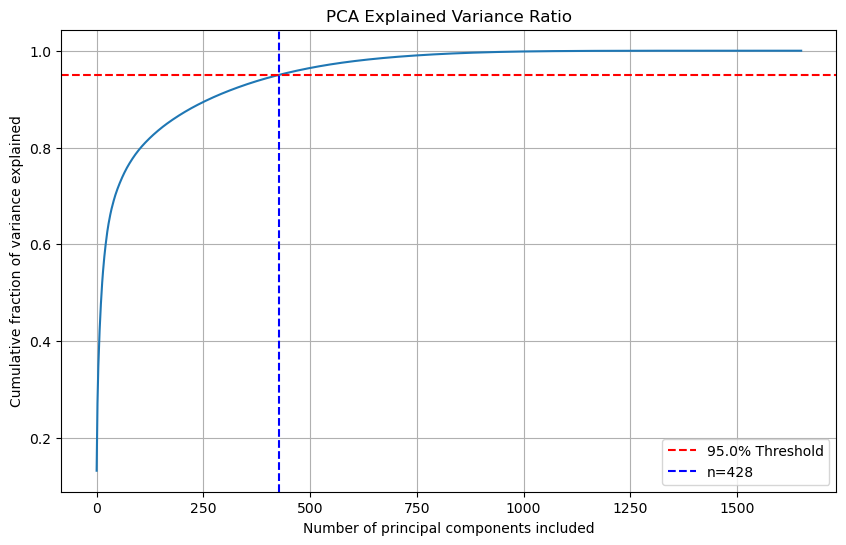

In [12]:
features, metadata = prepare_alignment_data(missing_values_filtered, BATCH_COLS, FIRST_FEATURE)

pca_df_threshold, n_components, pca, fig = pca_variance_plot(features, variance_threshold=0.95)

print("Top 10 pertubration counts:")
metadata[PERTURBATION_NAME_COL].value_counts()[:10]

## <font color='red'>SET PARAMETERS</font>

### Align and aggregate

- `PC_COUNT`: Number of principal components to use when creating embeddings with PCA (see figure above). Usually the amount of principal components needed to explain 95% of variance (see above).
- `CONTROL_KEY`: Name of perturbation in `PERTURBATION_NAME_COL` that indicates a control cell.
- `AGG_METHOD`: Method used to aggregate features. Can be `mean` or `median`. Usually `mean`.

In [13]:
PC_COUNT = 428
CONTROL_KEY = "nontargeting"
AGG_METHOD = "mean"

In [14]:
pca_embeddings = embed_by_pca(features.values, metadata, variance_or_ncomp=PC_COUNT, batch_col="batch_values")
tvn_normalized = tvn_on_controls(pca_embeddings, metadata, PERTURBATION_NAME_COL, CONTROL_KEY, "batch_values")

aggregated_embeddings, aggregated_metadata = aggregate(
    tvn_normalized, metadata, PERTURBATION_NAME_COL, method=AGG_METHOD
)

feature_columns = [f'PC_{i}' for i in range(tvn_normalized.shape[1])]

tvn_normalized_df = pd.DataFrame(tvn_normalized, index=metadata.index, columns=feature_columns)
aligned_cell_data = pd.concat([metadata, tvn_normalized_df], axis=1)

aggregated_embeddings_df = pd.DataFrame(aggregated_embeddings, index=aggregated_metadata.index, columns=feature_columns)
aggregated_cell_data = pd.concat([aggregated_metadata, aggregated_embeddings_df], axis=1).sort_values("cell_count", ascending=False).reset_index(drop=True)

aggregated_cell_data

/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/brieflow/workflow/lib/aggregate/align.py:168: ComplexWarning: Casting complex values to real discards the imaginary part
  embeddings[batch_ind] = np.matmul(
/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/brieflow/workflow/lib/aggregate/align.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  embeddings[batch_ind] = np.matmul(


,gene_symbol_0,cell_count,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,...,PC_418,PC_419,PC_420,PC_421,PC_422,PC_423,PC_424,PC_425,PC_426,PC_427
0,nontargeting,523,2.478366e-17,3.034937e-17,1.480651e-17,-6.792952e-18,7.302423e-17,5.646641e-17,5.349449e-17,-1.788457e-17,...,2.940074e-17,2.568585e-17,7.981718e-17,-1.316134e-17,-9.499518e-18,-2.335077e-17,1.103855e-17,-1.698238e-17,1.528414e-17,4.776294e-19
1,KLF5,22,4.509078e-02,3.077541e-02,-5.852622e-02,9.645586e-02,6.387796e-02,-9.745242e-02,2.393349e-02,-8.546466e-02,...,-1.669560e-02,1.197930e+00,3.020041e+00,-3.663612e+00,5.977793e+00,4.873923e-01,1.202709e+01,3.428695e+00,3.420690e-01,-3.686007e+00
2,DCAF13,22,5.373072e-02,-3.781224e-02,-1.872020e-01,-1.067998e-01,1.131710e-01,-2.363306e-01,9.989441e-02,4.632196e-02,...,1.199782e+00,-3.707658e+00,-9.795599e+00,8.954402e+00,-2.125960e+00,4.453197e+00,-1.347692e+00,-3.662832e+00,-4.048495e-01,-7.890399e-01
3,IREB2,21,8.596250e-02,2.940073e-01,2.903373e-02,-2.405674e-01,1.533062e-01,-1.970072e-01,1.013723e-01,1.453065e-01,...,4.326454e-01,6.445068e+00,1.255676e+01,3.287805e+01,9.383598e+00,7.597061e+00,-7.094838e+00,5.102239e+00,2.199253e+01,-3.358679e-01
4,ZNF286B,21,6.865459e-02,1.445940e-01,3.871599e-01,-4.143977e-02,8.549074e-02,3.934738e-02,1.061430e-01,9.265153e-02,...,-3.036816e+00,-8.406093e-01,-1.664874e+00,2.112977e+00,4.331105e+00,2.707558e+00,5.706802e+00,1.917078e+00,4.050512e-01,-2.232372e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,RTEL1,1,-1.361701e-02,-3.861521e-01,2.778765e-01,-2.547494e-01,3.052718e-01,1.121150e-01,1.332373e-01,3.171041e-01,...,-9.092790e-01,5.461698e+00,3.448811e+00,-8.427123e+00,1.335288e+00,-1.729482e+00,2.549918e+00,3.389173e+00,-2.614270e+00,3.988383e+00
4597,MED21,1,-4.735308e-02,2.668709e-01,-1.728585e-01,-9.361672e-01,-5.844547e-01,-2.203124e-01,-3.025125e-01,1.164019e+00,...,2.308572e+01,-6.224124e+01,-1.488031e+02,1.378069e+02,-3.174791e+01,6.041979e+01,-1.289674e+01,1.364722e+01,4.618310e+00,-2.583801e+01
4598,E2F1,1,3.577773e-02,-5.177622e-02,-9.554084e-01,-1.837396e-01,8.117522e-01,2.176173e-01,-2.892576e-01,-1.915350e-01,...,7.858543e-01,6.817114e+00,-3.556276e+00,7.489782e+00,3.780907e+00,4.212153e+00,-7.907066e+00,-3.752563e+00,6.833943e+00,-3.330060e+00
4599,TNFRSF12A,1,8.782394e-02,-4.941632e-01,-1.451577e-01,1.477697e-01,6.795940e-01,-2.654931e-02,-1.435128e-01,-3.440871e-02,...,-3.406400e+00,-5.329620e-01,2.223179e+00,-2.229121e+00,8.277429e+00,3.602469e+00,2.941467e+00,-1.418454e+00,-2.900569e+00,-3.294539e+00


## <font color='red'>SET PARAMETERS</font>

### Evaluate

- `COLLAPSE_COLS`: Columns to collapse on when creating a summary of cell counts.

In [15]:
COLLAPSE_COLS = ["sgRNA_0", "gene_symbol_0"]

Aligned feature distribtutions:


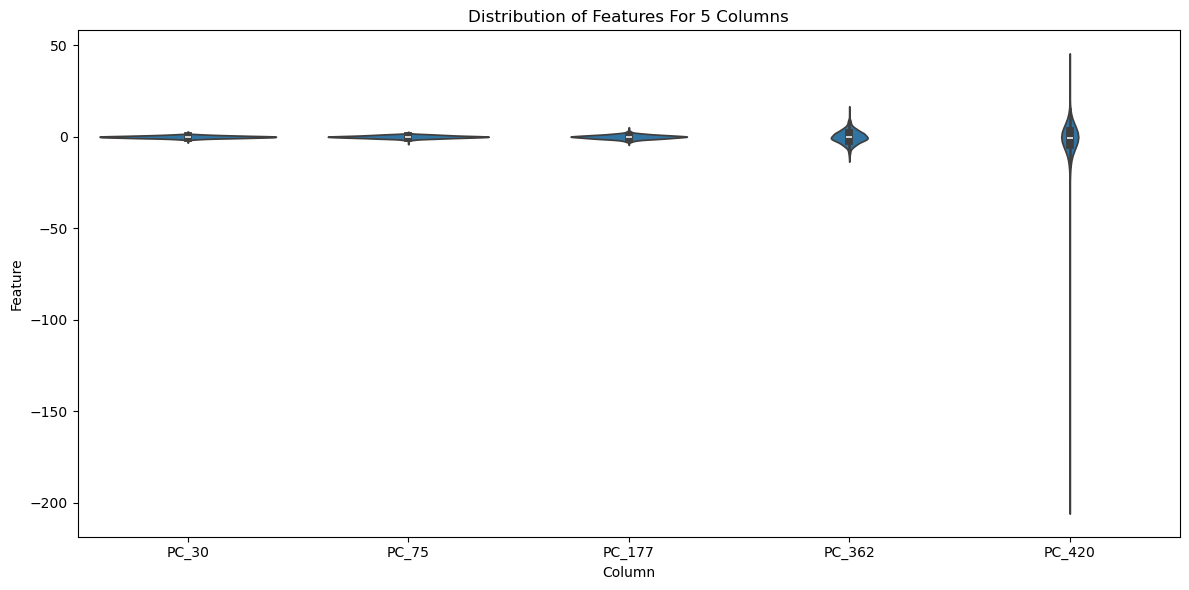

Aligned cell data summary:


,Stage,Count
0,Raw Data,22753
1,interphase cells,22624
2,interphase sgRNA_0,9544
3,interphase gene_symbol_0,4595
4,mitotic cells,129
5,mitotic sgRNA_0,125
6,mitotic gene_symbol_0,125


In [16]:
print("Aligned feature distribtutions:")
plot_feature_distributions(aligned_cell_data, "PC_0", num_features=5)

print("Aligned cell data summary:")
summary_df = summarize_cell_data(aligned_cell_data, CELL_CLASSES, COLLAPSE_COLS)
summary_df

## Add aggregate parameters to config file

In [17]:
# Add aggregate section
config["aggregate"] = {
    "classifier_path": CLASSIFIER_PATH,
    "first_feature": FIRST_FEATURE,
    "montage_channel": MONTAGE_CHANNEL,
    "datasets": DATASETS,
    "perturbation_name_col": PERTURBATION_NAME_COL,
    "perturbation_multi_col": PERTURBATION_MULTI_COL,
    "filter_single_pert": FILTER_SINGLE_PERT,
    "drop_cols_threshold": DROP_COLS_THRESHOLD,
    "batch_cols": BATCH_COLS,
    "pc_count": PC_COUNT,
    "control_key": CONTROL_KEY,
    "agg_method": AGG_METHOD,
    "collapse_cols": COLLAPSE_COLS,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)